# BMI 예측 — 회귀 딥러닝
이 노트에서는 제공된 `diabetes.csv` 데이터를 사용해 BMI(연속값)를 예측하는 딥러닝 회귀 모델을 구현합니다.

셀 구성:
1. 데이터 로드 및 간단한 EDA
2. 전처리(결손치 처리, 특성/타깃 분리, 표준화, train/test 분할)
3. Keras(텐서플로우) 기반 신경망 모델 학습(조기종료 포함)
4. 테스트 평가(MSE, MAE, R2) 및 예측 vs 실제 산점도/잔차 히스토그램
5. 간단한 sklearn 선형 회귀(베이스라인) 비교

노트: 이 노트는 TensorFlow(또는 Keras)가 로컬에 설치되어 있으면 Keras 모델을 사용합니다. 없다면 알려주시면 sklearn 기반 대체 모델을 더 확장해 드리겠습니다.

shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


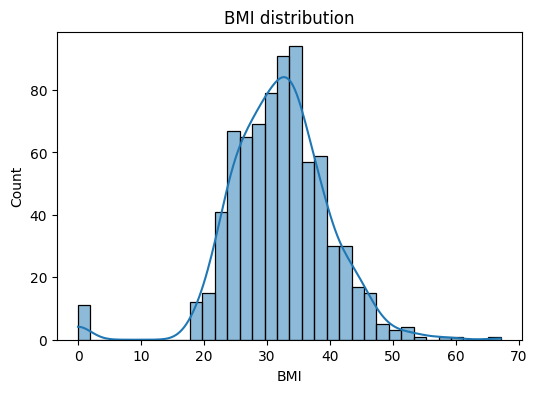

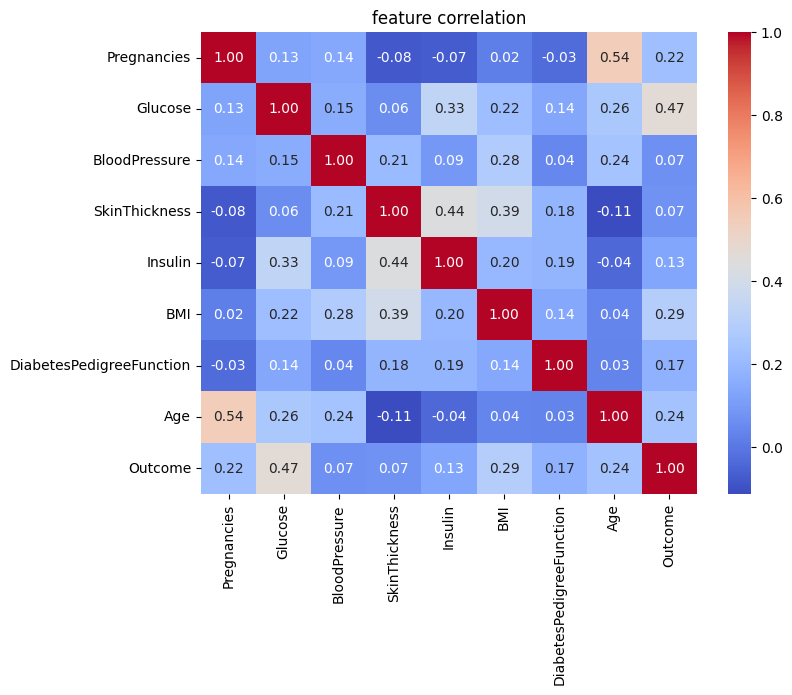

In [ ]:
# 1) 데이터 로드 및 간단 EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('diabetes.csv')
print('shape:', df.shape)
print(df.head())


In [2]:
# 2) 전처리: 결측(0으로 표기된 값) 처리, 특성/타깃 분리, 스케일링, 분할
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 일부 피처(Glucose, BloodPressure, SkinThickness, Insulin, BMI)에 0이 실제 결측값으로 쓰인 경우가 있음
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# 간단히 중앙값으로 대체
df.fillna(df.median(), inplace=True)

# 특성/타깃 분리
X = df.drop(columns=['BMI','Outcome'])  # Outcome은 분류 레이블이라 제거
y = df['BMI']

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)

X_train shape: (614, 7)


In [3]:
# 3) Keras 딥러닝 모델 학습 (회귀)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print('TensorFlow version:', tf.__version__)
    use_keras = True
except Exception as e:
    print('TensorFlow not available:', e)
    use_keras = False

if use_keras:
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # 회귀: 출력층 1개
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32, callbacks=[early], verbose=2)

    # 저장(선택)
    model.save('bmi_keras_model.h5')
else:
    print('Keras model skipped because TensorFlow is not installed. You can install with `pip install tensorflow`.')

TensorFlow version: 2.19.0
Epoch 1/200
18/18 - 1s - 45ms/step - loss: 1048.9578 - mae: 31.6426 - val_loss: 1074.7345 - val_mae: 32.0533
Epoch 2/200
18/18 - 0s - 4ms/step - loss: 926.9329 - mae: 29.6697 - val_loss: 923.4000 - val_mae: 29.5386
Epoch 3/200
18/18 - 0s - 4ms/step - loss: 745.9221 - mae: 26.4124 - val_loss: 697.4079 - val_mae: 25.2561
Epoch 4/200
18/18 - 0s - 4ms/step - loss: 506.3790 - mae: 21.1627 - val_loss: 430.9209 - val_mae: 19.2994
Epoch 5/200
18/18 - 0s - 4ms/step - loss: 262.1479 - mae: 14.3887 - val_loss: 226.4272 - val_mae: 13.2489
Epoch 6/200
18/18 - 0s - 4ms/step - loss: 128.8448 - mae: 9.2128 - val_loss: 149.4197 - val_mae: 9.5044
Epoch 7/200
18/18 - 0s - 4ms/step - loss: 99.9684 - mae: 7.9836 - val_loss: 134.1551 - val_mae: 8.4201
Epoch 8/200
18/18 - 0s - 4ms/step - loss: 84.4753 - mae: 7.3656 - val_loss: 125.2440 - val_mae: 8.2122
Epoch 9/200
18/18 - 0s - 4ms/step - loss: 81.2023 - mae: 7.1363 - val_loss: 119.2568 - val_mae: 8.1555
Epoch 10/200
18/18 - 0s - 4

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Keras model — MSE: 42.5309, MAE: 4.5893, R2: 0.0276


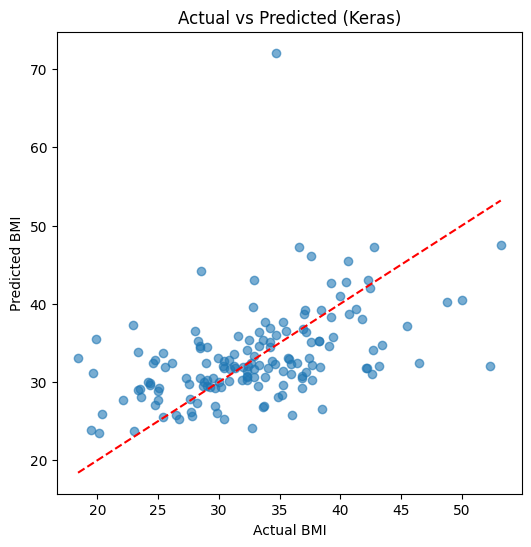

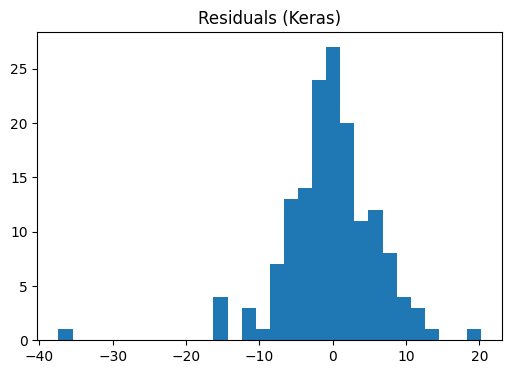


LinearRegression — MSE: 34.7884, MAE: 4.3867, R2: 0.2046


In [4]:
# 4) 평가: MSE, MAE, R2 및 예측 vs 실제 플롯
from sklearn import metrics
import numpy as np

if use_keras:
    y_pred = model.predict(X_test).flatten()
    mse = metrics.mean_squared_error(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    print(f'Keras model — MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual BMI')
    plt.ylabel('Predicted BMI')
    plt.title('Actual vs Predicted (Keras)')
    plt.show()

    # Residuals
    res = y_test - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(res, bins=30)
    plt.title('Residuals (Keras)')
    plt.show()
else:
    print('No Keras predictions to evaluate.')

# 5) 간단한 sklearn 선형 회귀와 비교
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('\nLinearRegression — MSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}'.format(
    metrics.mean_squared_error(y_test, y_pred_lr),
    metrics.mean_absolute_error(y_test, y_pred_lr),
    metrics.r2_score(y_test, y_pred_lr)
))